In [58]:
import copy
import itertools
import os
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from pydantic import BaseModel, Field
from transformers import AutoTokenizer

from semantic_chunkers import StatisticalChunker
# from semantic_router.encoders import OpenAIEncoder
from src.encoder import OpenAIEncoder

In [36]:
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../.env", env_file_encoding="utf-8", extra="ignore"
    )
    embedding_base_url: str
    embedding_api_key: str
    embedding_model: str
    embedding_model_dir: str
    
    sample_data_dir: str
    pipeline_src_dir: str
settings = Settings()

import sys
sys.path.append(settings.pipeline_src_dir)

In [4]:
from core.data.paper import ArxivPaperSection, ArxivPaperMetadata, ArxivPaper
from core.parser.md2py import TreeOfContents

from modules.extractor.section_splitter import MarkdownArxivPaperSectionSplitter

# 1. Load Encoder

In [38]:
# Use a custom OpenAIEncoder implementation to use local models
encoder = OpenAIEncoder(
    name= "{}/v1/".format(settings.embedding_base_url),
    base_url=settings.embedding_base_url,
    api_key=settings.embedding_api_key,
)

In [39]:
# StatisticalChunker options
# https://github.com/aurelio-labs/semantic-chunkers/blob/43ee0ac6ecdf76790de7d4ac4029f59438f34769/semantic_chunkers/chunkers/statistical.py#L49
chunker = StatisticalChunker(
    encoder=encoder,
    dynamic_threshold = True,
    window_size = 5,
    min_split_tokens = 256,
    max_split_tokens = 2048,
    plot_chunks = True,
    enable_statistics = True
)

# 2. Load Sample

In [7]:
## Load Sample
df = pd.read_parquet(settings.sample_data_dir)
df = df.sample(100)
print(df.shape, df.columns)

(100, 7) Index(['id', 'title', 'abstract', 'authors', 'published_date', 'link',
       'markdown'],
      dtype='object')


In [8]:
df.iloc[0]

id                                                       2303.06048
title             VALERIAN: Invariant Feature Learning for IMU S...
abstract          Deep neural network models for IMU sensor-base...
authors                           Yujiao Hao, Boyu Wang, Rong Zheng
published_date                                 2023-03-03T18:22:14Z
link                              http://arxiv.org/abs/2303.06048v1
markdown          # Valerian: Invariant Feature Learning for IMU...
Name: 50714, dtype: object

In [9]:
def get_sections(idx, text):
    # row = df.iloc[idx]
    # text = row['markdown']
    # found_filter = False
    
    sections = None
    for filter_cls in MarkdownArxivPaperSectionSplitter.__subclasses__():
        try:
            if filter_cls.is_type(text):
                # print("FOUND",filter_cls)
                found_filter = True
                sections = filter_cls().split(text)
                break
        except RecursionError as e:
            print("{} RECURSION ERROR {}".format(idx, str(e)))
            return idx, None
        except Exception as e:
            print("{} ERROR {}".format(idx, str(e)))
            # print(traceback.format_exc())
            raise e
    return idx, sections

In [16]:
texts = df.markdown.values.tolist()

results = [get_sections(idx, text) for idx, text in enumerate(texts)]
# Failed Count
failed_count = sum(1 for _, sections in results if sections is None or not sections)
print("Total {} failed {}".format(len(results), failed_count))

Total 100 failed 12


In [11]:
results[0]
processed_sections: List[List[ArxivPaperSection]] = [x[1] for x in results]

# 3.Analyze section children lengths
* split down to depth 2 (ex. 2.1)
```
class ArxivPaperSection(BaseModel):
    header: Literal["h2", "h3", "h4", "h5", "h6"]
    title:str = Field(..., description="Section title")
    text: str = Field("", description = "Section contents")
    children: List["ArxivPaperSection"] = Field(list(), description="child sections")
```

In [12]:
tokenizer = AutoTokenizer.from_pretrained(settings.embedding_model_dir)

In [18]:
def count_tokens(tokenizer, text):
    return len(tokenizer(text)['input_ids'])

count_tokens(tokenizer, 'hello world')

5

In [20]:
sample_sections = processed_sections[1]
sample_sections

[ArxivPaperSection(header='h2', title='1 Introduction', text='Machine learning is increasingly used to identify voice and text\\-based markers that complement current methods for screening and monitoring neuropsychiatric conditions \\[1, 2]. However, while clinical assessment often requires the identification of one diagnosis amongst many with partially overlapping clinical features, virtually all machine learning studies of voice and text\\-based markers focus on simpler binary outcomes, i.e., patients with one specific diagnosis *versus* controls without any neuropsychiatric conditions \\[3, 4, 5, 6, 7]. This raises concerns that the markers identified by studies in one\\-diagnosis settings may not have diagnostic specificity \\- instead capturing general differences\nbetween clinical and non\\-clinical populations.\n\n*versus*In this paper, we briefly review the rationale behind using voice and text\\-based markers of neuropsychiatric disorders, and the techniques available to do so

In [25]:
sample_sections[1].children

[ArxivPaperSection(header='p', title='', text='In this study, we trained binary and multi\\-class models on voice and transcripts from Danish adult individuals with a diagnosis of schizophrenia, MDD, or ASD as well as healthy matched controls performing the Animated Triangles (Frith\\-Happe) task \\[28]. We first assessed whether we can achieve binary classification performance comparable to existing studies. We then evaluated how well the same architectures performed in a multi\\-class setup. In order to extensively assess these issues, we used both voice recordings and text\\-based properties of transcribed speech, and contrasted more traditional machine learning approaches with pre\\-trained state\\-of\\-the\\-art Transformer models. The following sections provide details on the data and modelling strategies.', children=[]),
 ArxivPaperSection(header='h3', title='Pipeline', text='For training, we split the data into a training set, a validation set, and a balanced held\\-out test se

In [26]:
## Calculate Stats
all_children_num_tokens = []
for sections in processed_sections:
    if sections is None:
        continue
    for section in sections:
        section_children_num_tokens = [count_tokens(tokenizer, x.text) for x in section.children]
        all_children_num_tokens.extend(section_children_num_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (11088 > 8192). Running this sequence through the model will result in indexing errors


In [30]:
print("Avg {:.3f} Min {} Max {}".format(
    sum(all_children_num_tokens)/len(all_children_num_tokens),
    min(all_children_num_tokens),
    max(all_children_num_tokens),
))

Avg 2009.211 Min 10 Max 38678


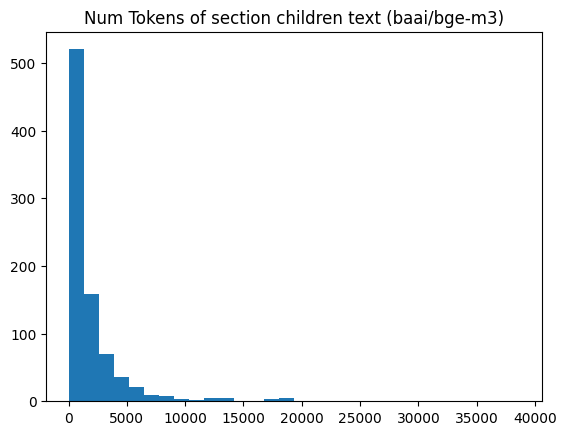

In [28]:
plt.hist(all_children_num_tokens, bins=30)
plt.title("Num Tokens of section children text (baai/bge-m3)")
plt.show()

# 4. Test Section Chunking

In [31]:
sample_section = None

for sections in processed_sections:
    if sections is None:
        continue
    for section in sections:
        section_children_num_tokens = [count_tokens(tokenizer, x.text) for x in section.children]
        if any([x>4000 for x in  section_children_num_tokens]):
            print("found sample", section_children_num_tokens)
            sample_section = section
            break
    if sample_section:
        break

found sample [32, 7971, 2978, 637]


In [45]:
children_text = [x.text for x in sample_section.children]

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/llm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/llm/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/llm/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/llm/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/miniconda3/envs/llm/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


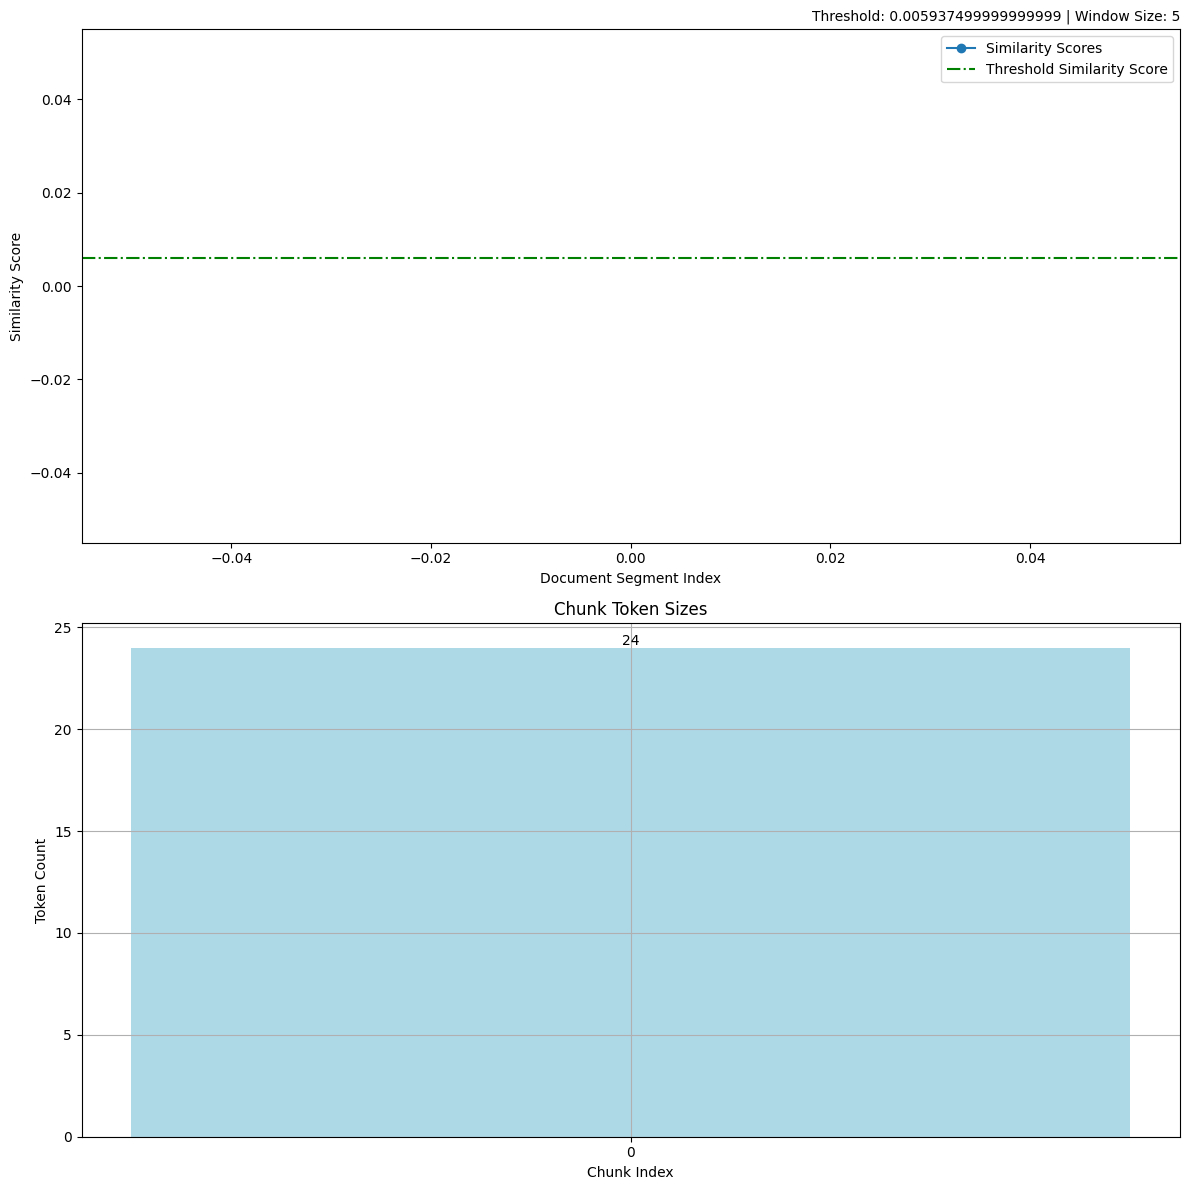

2025-01-01 17:04:53 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 2048. Splitting to sentences before semantically merging.


Chunking Statistics:
  - Total Documents: 1
  - Total Chunks: 1
  - Chunks by Threshold: 0
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 24
  - Maximum Token Size of Chunk: 24
  - Similarity Chunk Ratio: 0.00


  0%|          | 0/2 [00:00<?, ?it/s]

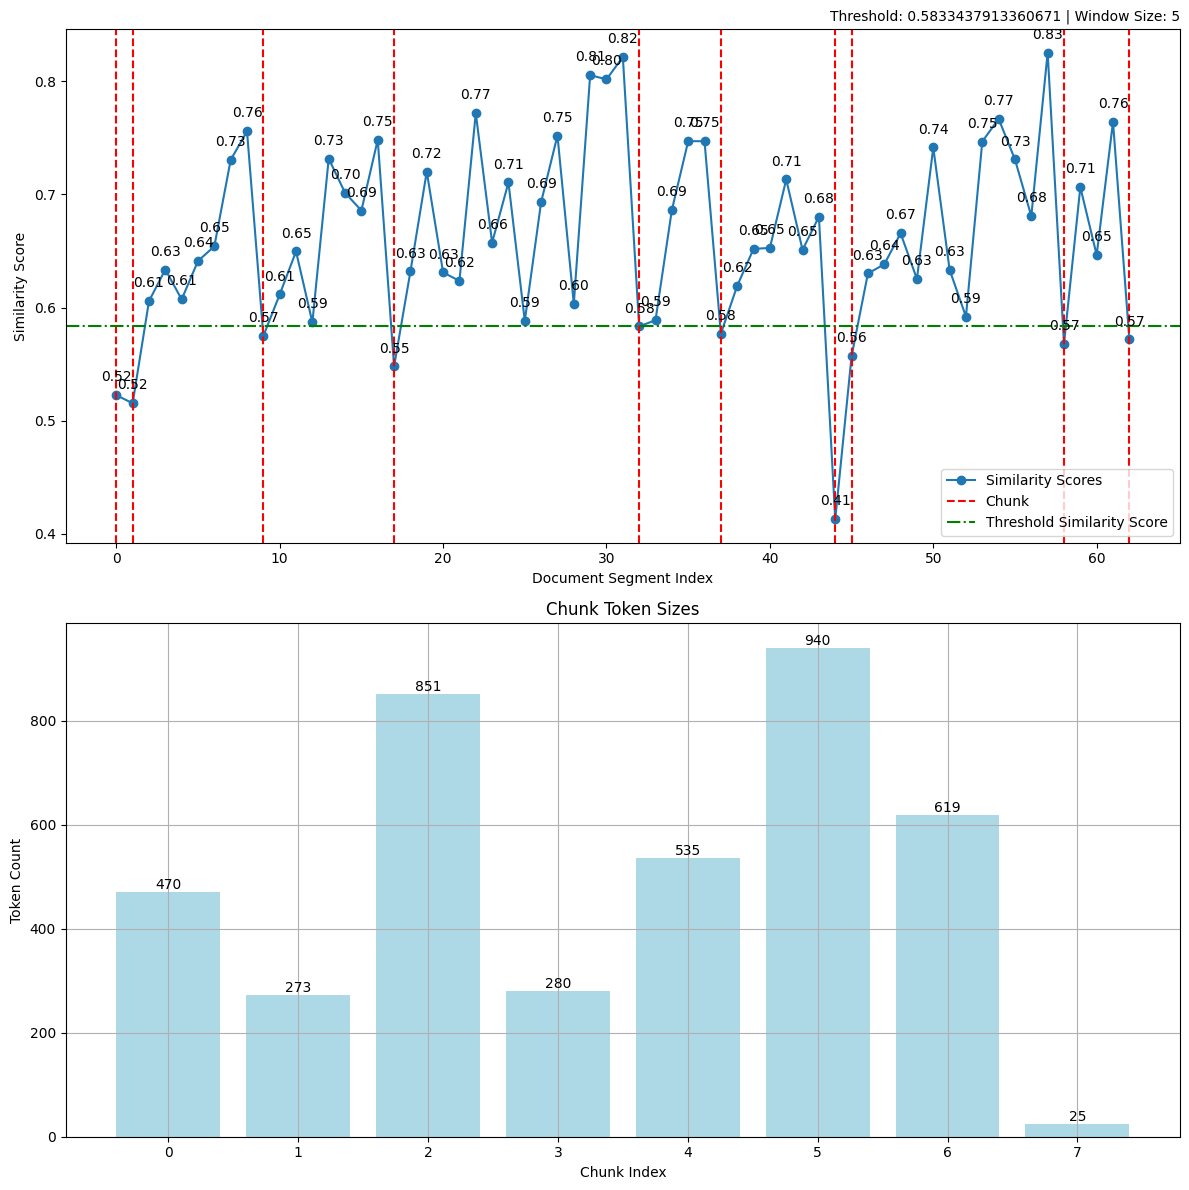

Chunking Statistics:
  - Total Documents: 64
  - Total Chunks: 8
  - Chunks by Threshold: 7
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 25
  - Maximum Token Size of Chunk: 940
  - Similarity Chunk Ratio: 0.88


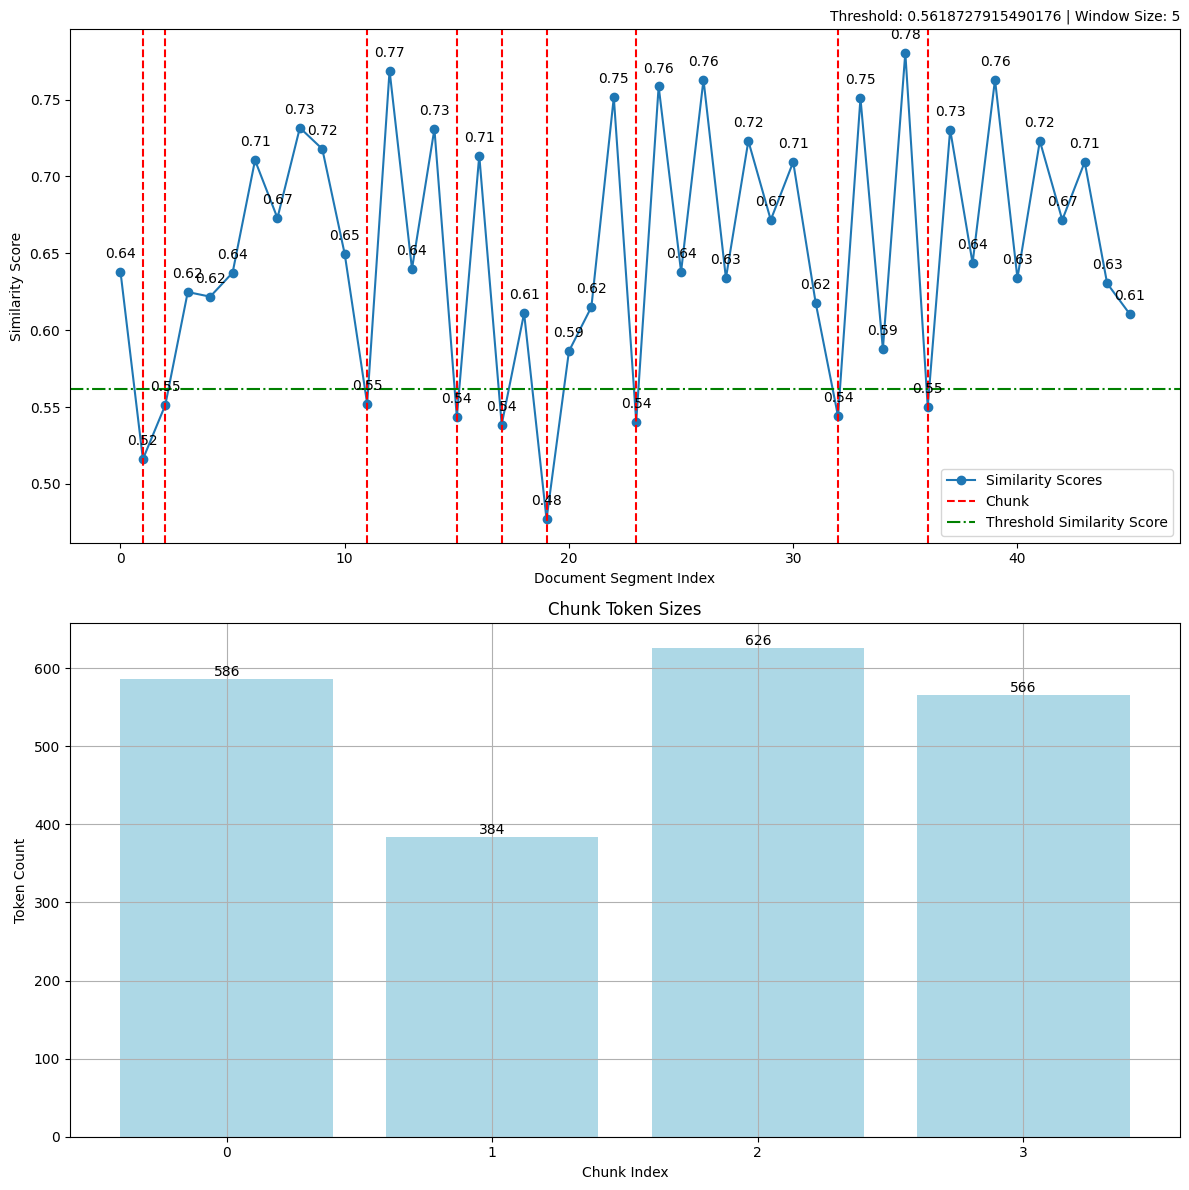

2025-01-01 17:05:18 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 2048. Splitting to sentences before semantically merging.


Chunking Statistics:
  - Total Documents: 47
  - Total Chunks: 4
  - Chunks by Threshold: 3
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 384
  - Maximum Token Size of Chunk: 626
  - Similarity Chunk Ratio: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

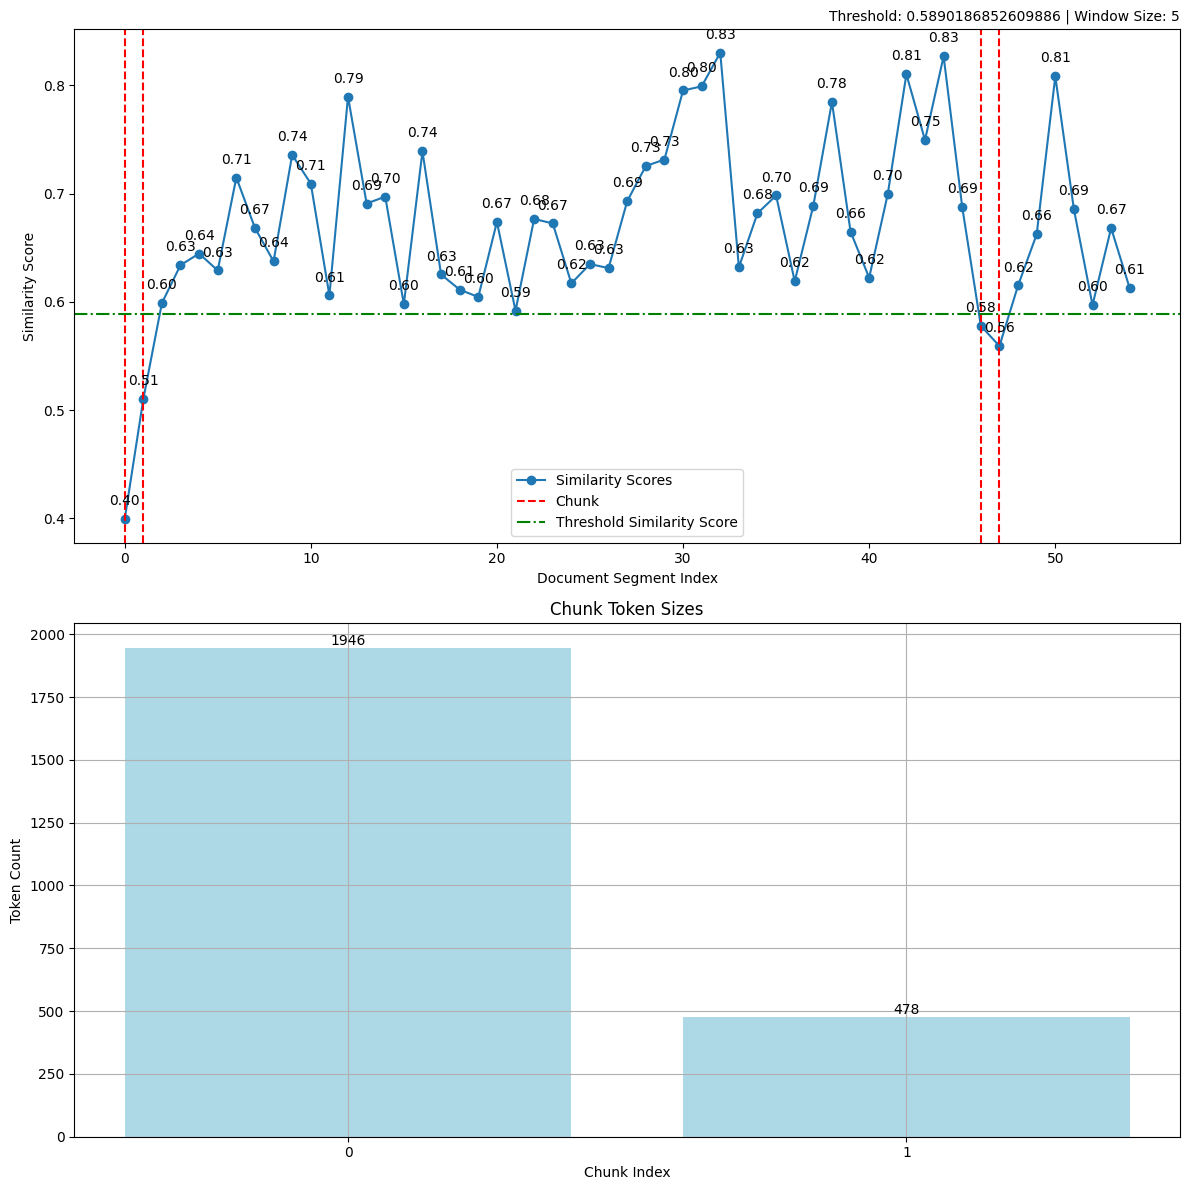

Chunking Statistics:
  - Total Documents: 56
  - Total Chunks: 2
  - Chunks by Threshold: 1
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 478
  - Maximum Token Size of Chunk: 1946
  - Similarity Chunk Ratio: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

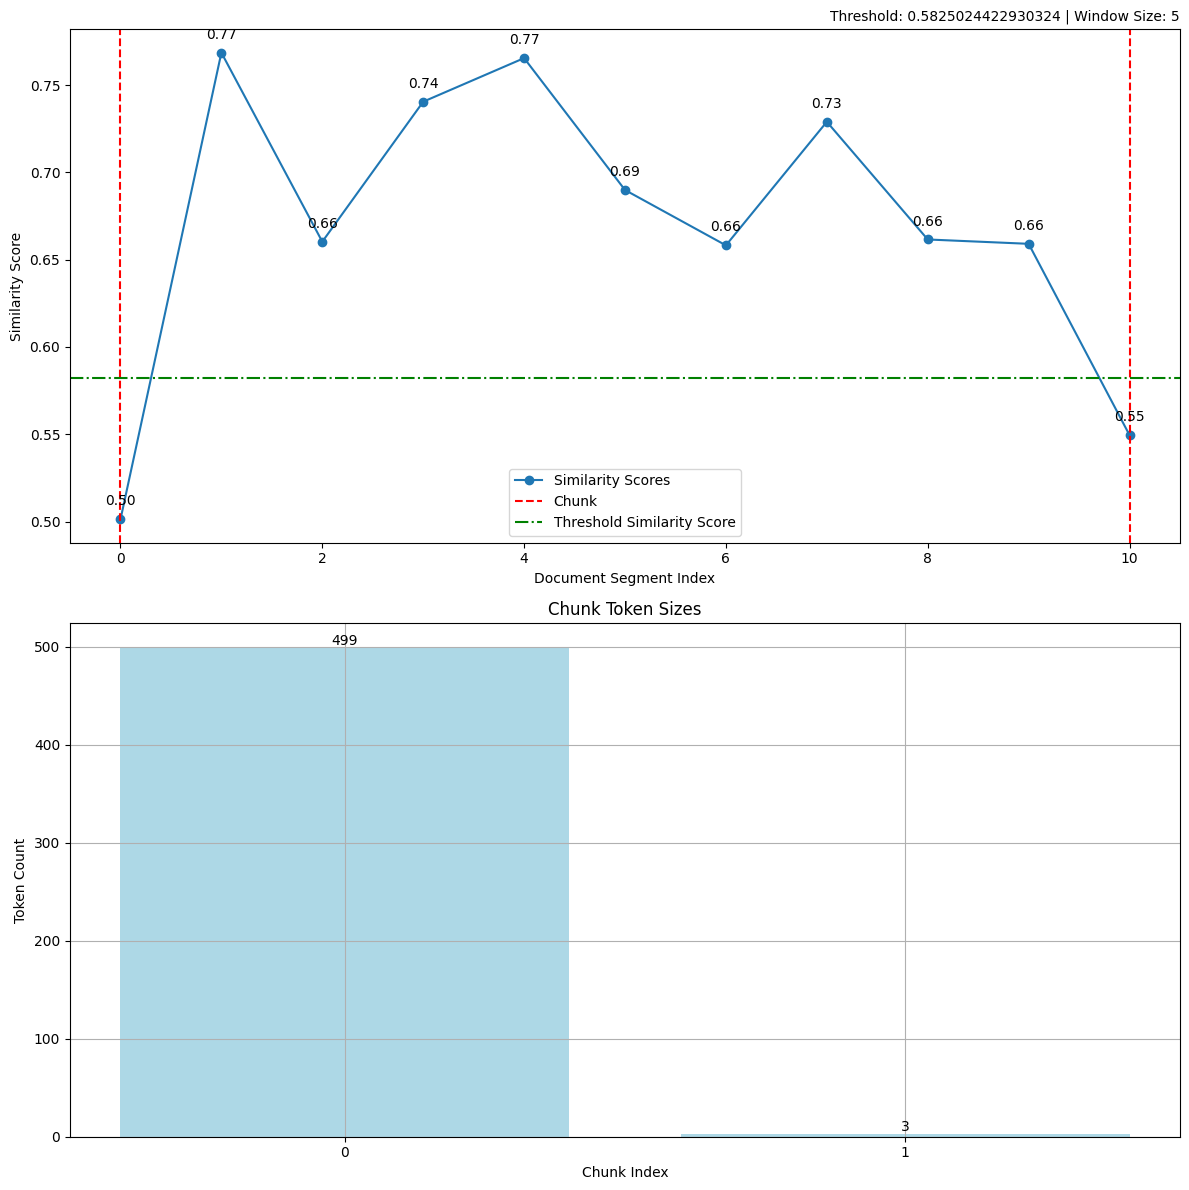

Chunking Statistics:
  - Total Documents: 12
  - Total Chunks: 2
  - Chunks by Threshold: 1
  - Chunks by Max Chunk Size: 0
  - Last Chunk: 1
  - Minimum Token Size of Chunk: 3
  - Maximum Token Size of Chunk: 499
  - Similarity Chunk Ratio: 0.50


In [47]:
chunks = chunker(docs=children_text)

In [48]:
chunks

[[Chunk(splits=['This section develops the main method proposed in this paper: a parallel\\-in\\-time probabilistic numerical ODE solver.'], is_triggered=False, triggered_score=None, token_count=24, metadata=None)],
 [Chunk(splits=['Let us first consider the simple case:', 'An initial value problem with affine vector field', '\\[\\\\dot{y}(t)\\=L(t)y(t)\\+d(t),\\\\quad t\\\\in\\[0,T],\\\\qquad y(0\\)\\=y\\_{0}. \\\\tag{12}]', 'The corresponding information model of the probabilistic solver is then also affine, with', '\\[Z(t)\\\\mid Y(t) \\\\sim\\\\delta\\\\left(H(t)Y(t)\\-d(t)\\\\right), \\\\tag{13a}] \\[H(t) \\\\coloneqq E\\_{1}\\-L(t)E\\_{0}. \\\\tag{13b}]', 'Let (\\\\mathbb{T}\\={t\\_{n}}*{n\\=1}^{N}\\\\subset\\[0,T]) be a discrete time grid.', 'To simplify the notation in the following, we will denote a function evaluated at time (t*{n}) by a subscript (n), that is (Y(t\\_{n})\\=:Y\\_{n}), except for the transition matrices where we will use (\\\\Phi\\_{n}\\\\coloneqq\\\\Phi(t\\_{

In [ ]:
chunk_texts = [
    ["\n".join(x.splits) for x in child_chunks]
    for child_chunks in chunks
]

## Merge


chunk_text_lens = [
    [count_tokens(tokenizer, x) for x in child_chunk_texts]
    for child_chunk_texts in chunk_texts
]
print(chunk_text_lens)

[[32], [606, 321, 1057, 350, 687, 1212, 825, 781, 511, 868, 773], [2393, 587], [632, 7]]


In [76]:
def merge_short_chunks(chunk_texts: List[str]):
    if len(chunk_texts)<2:
        return chunk_texts
    chunk_token_counts = [count_tokens(tokenizer, x) for x in chunk_texts]
    
    merged_chunk_texts = []
    i = 0
    while i < len(chunk_texts):
        if chunk_token_counts[i]<128:
            if merged_chunk_texts:
                merged_chunk_texts[-1]+=chunk_texts[i]
                i+=1
                continue
            else:
                new_chunk_text = chunk_texts[i]
                i+=1
                while i < len(chunk_texts):
                    if count_tokens(tokenizer, new_chunk_text)>128:
                        break
                    new_chunk_text += "\n"+chunk_texts[i]
                    i+=1
                merged_chunk_texts.append(new_chunk_text)
                    
        else:
            merged_chunk_texts.append(chunk_texts[i])
            i+=1
    return merged_chunk_texts

print(len(chunk_texts[-1]))
print([count_tokens(tokenizer, x) for x in chunk_texts[-1]])
merged_chunk_texts = merge_short_chunks(chunk_texts[-1])
print(len(merged_chunk_texts))
print([count_tokens(tokenizer, x) for x in merged_chunk_texts])

2
[632, 7]
1
[637]


In [78]:
chunk_texts = [merge_short_chunks(x) for x in chunk_texts]
chunk_texts

[['This section develops the main method proposed in this paper: a parallel\\-in\\-time probabilistic numerical ODE solver.'],
 ['Let us first consider the simple case:\nAn initial value problem with affine vector field\n\\[\\\\dot{y}(t)\\=L(t)y(t)\\+d(t),\\\\quad t\\\\in\\[0,T],\\\\qquad y(0\\)\\=y\\_{0}. \\\\tag{12}]\nThe corresponding information model of the probabilistic solver is then also affine, with\n\\[Z(t)\\\\mid Y(t) \\\\sim\\\\delta\\\\left(H(t)Y(t)\\-d(t)\\\\right), \\\\tag{13a}] \\[H(t) \\\\coloneqq E\\_{1}\\-L(t)E\\_{0}. \\\\tag{13b}]\nLet (\\\\mathbb{T}\\={t\\_{n}}*{n\\=1}^{N}\\\\subset\\[0,T]) be a discrete time grid.\nTo simplify the notation in the following, we will denote a function evaluated at time (t*{n}) by a subscript (n), that is (Y(t\\_{n})\\=:Y\\_{n}), except for the transition matrices where we will use (\\\\Phi\\_{n}\\\\coloneqq\\\\Phi(t\\_{n\\+1}\\-t\\_{n})) and (Q\\_{n}\\\\coloneqq Q(t\\_{n\\+1}\\-t\\_{n})).\nThen, the Bayesian state estimation problem

# 5. Format Chunks & Embed

In [ ]:
# def format_chunk(section, )

In [59]:
sample_section

ArxivPaperSection(header='h2', title='3 Parallel-in-Time Probabilistic Numerical ODE Solvers', text='This section develops the main method proposed in this paper: a parallel\\-in\\-time probabilistic numerical ODE solver.\n\n### Parallel\\-Time Exact Inference in Affine Vector Fields\n\nLet us first consider the simple case: An initial value problem with affine vector field\n\n\\[\\\\dot{y}(t)\\=L(t)y(t)\\+d(t),\\\\quad t\\\\in\\[0,T],\\\\qquad y(0\\)\\=y\\_{0}. \\\\tag{12}]\n\nThe corresponding information model of the probabilistic solver is then also affine, with\n\n\\[Z(t)\\\\mid Y(t) \\\\sim\\\\delta\\\\left(H(t)Y(t)\\-d(t)\\\\right), \\\\tag{13a}] \\[H(t) \\\\coloneqq E\\_{1}\\-L(t)E\\_{0}. \\\\tag{13b}]\n\nLet (\\\\mathbb{T}\\={t\\_{n}}*{n\\=1}^{N}\\\\subset\\[0,T]) be a discrete time grid. To simplify the notation in the following, we will denote a function evaluated at time (t*{n}) by a subscript (n), that is (Y(t\\_{n})\\=:Y\\_{n}), except for the transition matrices where we

In [61]:
count_tokens(tokenizer, sample_section.text)

11671

In [79]:
p_chunk_template = '''Section Title: "{section_title}"
Text:
{text}'''

h3_chunk_template = '''Section Title: "{section_title}"
Subsection Title: "{subsection_title}"
Text:
{text}'''

In [80]:
section_header = sample_section.header
section_title = sample_section.title

formatted_chunks = []

for child, child_chunk_texts in zip(sample_section.children, chunk_texts):
    child_header = child.header
    child_title = child.title
    print(child)
    
    for chunk_text in child_chunk_texts:
        if child_header=="p":
            formatted_chunk_text = copy.deepcopy(p_chunk_template)
            formatted_chunk_text = formatted_chunk_text.format(
                section_title=section_title,
                text=chunk_text
            )
        else:
            formatted_chunk_text = copy.deepcopy(h3_chunk_template)
            formatted_chunk_text = formatted_chunk_text.format(
                section_title=section_title,
                subsection_title=child_title,
                text=chunk_text
            )
        formatted_chunks.append(formatted_chunk_text)

header='p' title='' text='This section develops the main method proposed in this paper: a parallel\\-in\\-time probabilistic numerical ODE solver.' children=[]
header='h3' title='Parallel\\-Time Exact Inference in Affine Vector Fields' text='Let us first consider the simple case: An initial value problem with affine vector field  \n\\[\\\\dot{y}(t)\\=L(t)y(t)\\+d(t),\\\\quad t\\\\in\\[0,T],\\\\qquad y(0\\)\\=y\\_{0}. \\\\tag{12}]  \nThe corresponding information model of the probabilistic solver is then also affine, with  \n\\[Z(t)\\\\mid Y(t) \\\\sim\\\\delta\\\\left(H(t)Y(t)\\-d(t)\\\\right), \\\\tag{13a}] \\[H(t) \\\\coloneqq E\\_{1}\\-L(t)E\\_{0}. \\\\tag{13b}]  \nLet (\\\\mathbb{T}\\={t\\_{n}}*{n\\=1}^{N}\\\\subset\\[0,T]) be a discrete time grid. To simplify the notation in the following, we will denote a function evaluated at time (t*{n}) by a subscript (n), that is (Y(t\\_{n})\\=:Y\\_{n}), except for the transition matrices where we will use (\\\\Phi\\_{n}\\\\coloneqq\\\\Phi(t\

In [81]:
formatted_chunks

['Section Title: "3 Parallel-in-Time Probabilistic Numerical ODE Solvers"\nText:\nThis section develops the main method proposed in this paper: a parallel\\-in\\-time probabilistic numerical ODE solver.',
 'Section Title: "3 Parallel-in-Time Probabilistic Numerical ODE Solvers"\nSubsection Title: "Parallel\\-Time Exact Inference in Affine Vector Fields"\nText:\nLet us first consider the simple case:\nAn initial value problem with affine vector field\n\\[\\\\dot{y}(t)\\=L(t)y(t)\\+d(t),\\\\quad t\\\\in\\[0,T],\\\\qquad y(0\\)\\=y\\_{0}. \\\\tag{12}]\nThe corresponding information model of the probabilistic solver is then also affine, with\n\\[Z(t)\\\\mid Y(t) \\\\sim\\\\delta\\\\left(H(t)Y(t)\\-d(t)\\\\right), \\\\tag{13a}] \\[H(t) \\\\coloneqq E\\_{1}\\-L(t)E\\_{0}. \\\\tag{13b}]\nLet (\\\\mathbb{T}\\={t\\_{n}}*{n\\=1}^{N}\\\\subset\\[0,T]) be a discrete time grid.\nTo simplify the notation in the following, we will denote a function evaluated at time (t*{n}) by a subscript (n), that i